## <font color = 'C2B515' >  Assignment-2 ::  Cat Dog Classification :: ML Operations implementation </font>

### Group ID: <font color = 'ORANGE' > **84** </font>
### Group Members Name with Student ID:

| Sl No | BITS ID | Name | Contribution |
|-----------|---------|---------|---------|
| 1 | 2024aa05486 | LAKSHMI RAMYA VEMURI  | 100% |
| 2 | 2024aa05487 | SUBHASISH DATTA  | 100% |
| 3 | 2024aa05488 | PUPPALA V V SUDHAKAR  | 100% |
| 4 | 2024aa05489 | K SREELAXMI  | 100% |
| 4 | 2024aa05490 | KHUSWANT SINGH RATHORE  | 100% |


# M1: Model Development & Experiment Tracking

**Objective:** Build a baseline model, track experiments, and version all artifacts.

**Tasks:**
1. Data & Code Versioning (Git, DVC)
2. Model Building (SimpleCNN)
3. Experiment Tracking (MLflow)

---

## 1. Setup and Imports

In [ ]:
# Install required packages (if not already installed)
!pip install torch torchvision mlflow dvc matplotlib seaborn pandas numpy scikit-learn

In [2]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

# Add parent directory to path to import our modules
sys.path.append(os.path.abspath('..'))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import mlflow
import mlflow.pytorch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm.notebook import tqdm

# Import our custom modules
from src.model import SimpleCNN, get_model
from src.data_preprocessing import get_transforms, normalize_image, prepare_data_loaders
from src.train import Trainer

from collections import defaultdict
from sklearn.model_selection import train_test_split

print("✓ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ All imports successful!
PyTorch version: 2.9.1
CUDA available: False


## 2. Data Versioning with DVC

DVC (Data Version Control) is used to track and version datasets. These commands are run outside the notebooks

In [11]:
# Initialize DVC (if not already initialized)
# This should be done once in your project

#!git init
#!dvc init -f
#!dvc remote add -d local /tmp/dvc-storage
#!dvc add data/processed
#!git add data/processed.dvc .dvc/config
#!git commit -m "Add data versioning with DVC"

print("DVC Configuration:")
print("- Local remote storage configured at /tmp/dvc-storage")
print("- Data files tracked in data/processed.dvc")
print("- Run 'dvc push' to upload data to remote storage")
print("- Run 'dvc pull' to download data from remote storage")



DVC Configuration:
- Local remote storage configured at /tmp/dvc-storage
- Data files tracked in data/processed.dvc
- Run 'dvc push' to upload data to remote storage
- Run 'dvc pull' to download data from remote storage


## 3. Load Actual Dataset from PetImages

Load the real Cats vs Dogs dataset from the PetImages directory with proper validation and train/val split.

In [12]:
def load_dataset_from_petimages(
    root_dir: str = '../PetImages',
    train_split: float = 0.8,
    random_seed: int = 42
) -> tuple:
    """
    Load dataset from PetImages directory structure.
    Handles corrupted images gracefully.
    
    Args:
        root_dir: Path to PetImages root directory
        train_split: Fraction of data to use for training (default 0.8 for 80% train, 20% val)
        random_seed: Random seed for reproducibility
        
    Returns:
        Tuple of (train_paths, train_labels, val_paths, val_labels)
    """
    print(f"Loading dataset from {root_dir}...")
    
    all_image_paths = []
    all_labels = []
    
    # Class labels: 0 for Cat, 1 for Dog
    class_labels = {'Cat': 0, 'Dog': 1}
    class_stats = defaultdict(int)
    corrupted_images = defaultdict(int)
    
    # Scan each class directory
    for class_name, label in class_labels.items():
        class_dir = os.path.join(root_dir, class_name)
        
        if not os.path.exists(class_dir):
            print(f"Warning: Directory not found: {class_dir}")
            continue
            
        print(f"\nProcessing {class_name} images from {class_dir}...")
        
        # Get all image files
        image_extensions = ('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')
        image_files = [
            f for f in os.listdir(class_dir) 
            if os.path.isfile(os.path.join(class_dir, f)) and 
            f.lower().endswith(image_extensions)
        ]
        
        print(f"Found {len(image_files)} image files in {class_name} directory")
        
        # Validate and load image paths
        valid_count = 0
        for idx, image_file in enumerate(image_files):
            image_path = os.path.join(class_dir, image_file)
            
            try:
                # Try to open and verify the image
                with Image.open(image_path) as img:
                    # Verify it's a valid image with content
                    if img.size[0] > 0 and img.size[1] > 0:
                        all_image_paths.append(image_path)
                        all_labels.append(label)
                        valid_count += 1
            except Exception:
                corrupted_images[class_name] += 1
            
            # Progress update every 2000 images
            if (idx + 1) % 2000 == 0:
                print(f"  Processed {idx + 1}/{len(image_files)} {class_name} images...")
        
        class_stats[class_name] = valid_count
        print(f"✓ {class_name}: {valid_count} valid images, {corrupted_images[class_name]} corrupted")
    
    # Print dataset statistics
    total_images = sum(class_stats.values())
    total_corrupted = sum(corrupted_images.values())
    print(f"\n{'='*60}")
    print(f"Dataset Statistics:")
    print(f"{'='*60}")
    print(f"Total valid images: {total_images}")
    print(f"Total corrupted images: {total_corrupted}")
    for class_name, count in class_stats.items():
        print(f"  {class_name}: {count} images")
    print(f"{'='*60}\n")
    
    if total_images == 0:
        raise ValueError("Dataset is empty")
    
    # Split data into train and validation sets
    print(f"Splitting data: {int(train_split*100)}% train, {int((1-train_split)*100)}% validation...")
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        all_image_paths,
        all_labels,
        test_size=1 - train_split,
        random_state=random_seed,
        stratify=all_labels  # Ensure balanced split between classes
    )
    
    print(f"Training set: {len(train_paths)} images")
    print(f"Validation set: {len(val_paths)} images")
    
    # Verify split balance
    train_cat_count = sum(1 for label in train_labels if label == 0)
    train_dog_count = sum(1 for label in train_labels if label == 1)
    val_cat_count = sum(1 for label in val_labels if label == 0)
    val_dog_count = sum(1 for label in val_labels if label == 1)
    
    print(f"\nTrain set balance - Cats: {train_cat_count}, Dogs: {train_dog_count}")
    print(f"Val set balance - Cats: {val_cat_count}, Dogs: {val_dog_count}\n")
    
    return train_paths, train_labels, val_paths, val_labels


# Load the actual dataset
print("Loading PetImages dataset...\n")
train_paths, train_labels, val_paths, val_labels = load_dataset_from_petimages(
    root_dir='../PetImages',
    train_split=0.8
)

Loading PetImages dataset...

Loading dataset from ../PetImages...

Processing Cat images from ../PetImages/Cat...
Found 12499 image files in Cat directory
  Processed 2000/12499 Cat images...
  Processed 4000/12499 Cat images...
  Processed 6000/12499 Cat images...
  Processed 8000/12499 Cat images...
  Processed 10000/12499 Cat images...
  Processed 12000/12499 Cat images...
✓ Cat: 12499 valid images, 0 corrupted

Processing Dog images from ../PetImages/Dog...
Found 12499 image files in Dog directory
  Processed 2000/12499 Dog images...
  Processed 4000/12499 Dog images...
  Processed 6000/12499 Dog images...
  Processed 8000/12499 Dog images...
  Processed 10000/12499 Dog images...
  Processed 12000/12499 Dog images...
✓ Dog: 12499 valid images, 0 corrupted

Dataset Statistics:
Total valid images: 24998
Total corrupted images: 0
  Cat: 12499 images
  Dog: 12499 images

Splitting data: 80% train, 19% validation...
Training set: 19998 images
Validation set: 5000 images

Train set bala

In [13]:
# Create DataLoaders using the preprocessing module
batch_size = 32

# Detect if running on MPS (Apple Silicon)
import torch
is_mps = torch.backends.mps.is_available() and torch.device('mps')

# Set pin_memory=False if using MPS, else True
pin_memory = False if is_mps else True

train_loader, val_loader = prepare_data_loaders(
    train_paths, train_labels,
    val_paths, val_labels,
    batch_size=batch_size,
    num_workers=2,
    pin_memory=pin_memory
)

print(f"Batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"\n✓ Data loaders created successfully!")

Batch size: 32
Number of training batches: 625
Number of validation batches: 157

✓ Data loaders created successfully!


Displaying sample images from both categories:



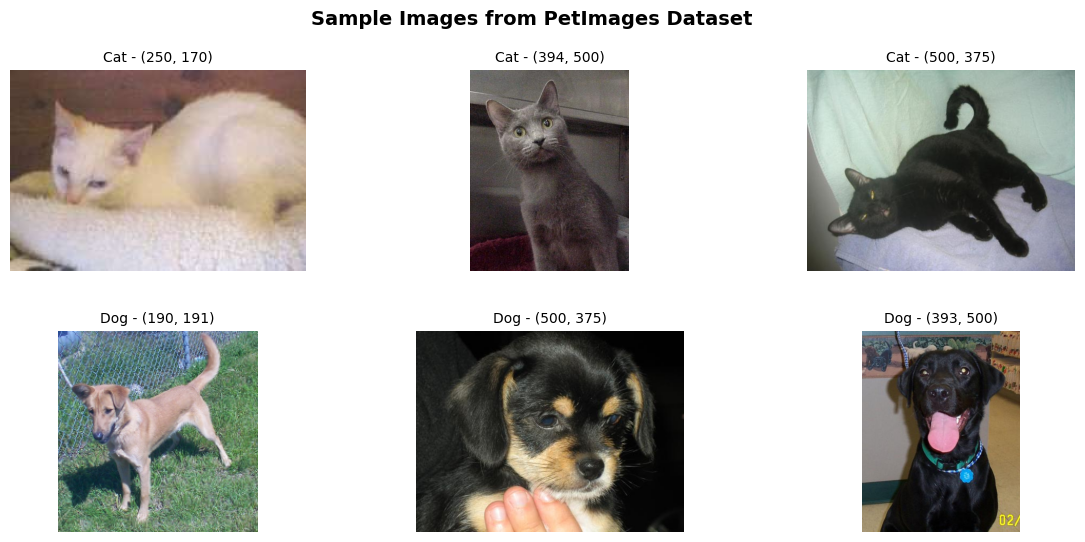


✓ Sample images displayed successfully!


In [14]:
# Display Sample Images from Both Categories
import matplotlib.gridspec as gridspec

def plot_sample_images(train_paths, train_labels, num_samples=3):
    """
    Display sample images from both Cat and Dog categories
    """
    # Get sample indices for each class
    cat_indices = [i for i, label in enumerate(train_labels) if label == 0][:num_samples]
    dog_indices = [i for i, label in enumerate(train_labels) if label == 1][:num_samples]
    
    fig = plt.figure(figsize=(14, 6))
    gs = gridspec.GridSpec(2, num_samples, figure=fig, hspace=0.3, wspace=0.3)
    
    class_names = ['Cat', 'Dog']
    
    # Display cat samples
    for i, idx in enumerate(cat_indices):
        img_path = train_paths[idx]
        try:
            img = Image.open(img_path).convert('RGB')
            ax = fig.add_subplot(gs[0, i])
            ax.imshow(img)
            ax.set_title(f'Cat - {img.size}', fontsize=10)
            ax.axis('off')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    
    # Display dog samples
    for i, idx in enumerate(dog_indices):
        img_path = train_paths[idx]
        try:
            img = Image.open(img_path).convert('RGB')
            ax = fig.add_subplot(gs[1, i])
            ax.imshow(img)
            ax.set_title(f'Dog - {img.size}', fontsize=10)
            ax.axis('off')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    
    plt.suptitle('Sample Images from PetImages Dataset', fontsize=14, fontweight='bold')
    plt.show()

# Plot sample images
print("Displaying sample images from both categories:\n")
plot_sample_images(train_paths, train_labels, num_samples=3)

print("\n✓ Sample images displayed successfully!")

## 4. Model Architecture

Build the SimpleCNN model for binary classification.

In [15]:
# Create model
model = get_model(num_classes=2)

# Display model information
info = model.get_model_info()
print("Model Information:")
print(f"  Name: {info['model_name']}")
print(f"  Total Parameters: {info['total_parameters']:,}")
print(f"  Trainable Parameters: {info['trainable_parameters']:,}")
print("\nModel Architecture:")
print(model)

Model Information:
  Name: SimpleCNN
  Total Parameters: 26,145,922
  Trainable Parameters: 26,145,922

Model Architecture:
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc

## 5. MLflow Experiment Tracking Setup

Configure MLflow to track experiments, parameters, metrics, and artifacts.

In [24]:
# Set MLflow tracking URI and experiment name
mlflow.set_tracking_uri("file:../mlruns")
experiment_name = "cats-dogs-classification"
mlflow.set_experiment(experiment_name)

print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment: {experiment_name}")
print("\nTo view experiments, run: mlflow ui")

MLflow Tracking URI: file:../mlruns
Experiment: cats-dogs-classification

To view experiments, run: mlflow ui


## 6. Training with MLflow Tracking

Train the model with full experiment tracking.

In [25]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Training hyperparameters
learning_rate = 0.001
num_epochs = 3

# Create trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    learning_rate=learning_rate,
    num_epochs=num_epochs,
    experiment_name=experiment_name
)

print("Trainer initialized!")
print(f"Learning Rate: {learning_rate}")
print(f"Number of Epochs: {num_epochs}")

Using device: cpu
Trainer initialized!
Learning Rate: 0.001
Number of Epochs: 3


In [10]:
# Train the model with MLflow tracking
print("Starting training...\n")

results = trainer.train(model_save_path='../models/model.pt')

print("\n" + "="*50)
print("Training Complete!")
print("="*50)
print(f"Best Validation Accuracy: {results['best_val_accuracy']:.4f}")
print(f"Final Training Loss: {results['final_train_loss']:.4f}")
print(f"Final Validation Loss: {results['final_val_loss']:.4f}")
# Each epoch number is already printed by the Trainer class

Starting training...


Epoch 1/10


Training:   3%|▎         | 17/625 [00:28<14:28,  1.43s/it, loss=2.32]/opt/miniconda3/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 157/157 [01:27<00:00,  1.80it/s]



Epoch 2/10


Training:  92%|█████████▏| 574/625 [11:10<00:56,  1.12s/it, loss=0.762]/opt/miniconda3/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 157/157 [01:07<00:00,  2.31it/s]



Epoch 3/10


Training:  84%|████████▍ | 525/625 [10:17<01:59,  1.20s/it, loss=0.643]/opt/miniconda3/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 157/157 [01:10<00:00,  2.23it/s]



Epoch 4/10


Training:  96%|█████████▌| 601/625 [11:24<00:27,  1.13s/it, loss=0.516]/opt/miniconda3/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 157/157 [01:07<00:00,  2.32it/s]



Epoch 5/10


Training:  39%|███▊      | 241/625 [04:42<07:40,  1.20s/it, loss=0.581]/opt/miniconda3/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 157/157 [01:07<00:00,  2.32it/s]



Epoch 6/10


Training:  68%|██████▊   | 425/625 [08:20<04:18,  1.29s/it, loss=0.353]/opt/miniconda3/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s]



Epoch 7/10


Training:   2%|▏         | 13/625 [00:18<11:44,  1.15s/it, loss=0.45] /opt/miniconda3/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 157/157 [01:07<00:00,  2.32it/s]



Epoch 8/10


Training:  22%|██▏       | 136/625 [02:47<10:07,  1.24s/it, loss=0.373]/opt/miniconda3/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 157/157 [01:08<00:00,  2.30it/s]



Epoch 9/10


Training:  54%|█████▍    | 340/625 [07:00<05:51,  1.23s/it, loss=0.633]/opt/miniconda3/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 157/157 [01:07<00:00,  2.32it/s]



Epoch 10/10


Training:  38%|███▊      | 235/625 [04:48<07:43,  1.19s/it, loss=0.337]/opt/miniconda3/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 157/157 [01:08<00:00,  2.30it/s]
2026/02/21 04:12:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/21 04:12:04 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.



Training Complete!
Best Validation Accuracy: 0.8886
Final Training Loss: 0.3247
Final Validation Loss: 0.2833


## 7. Visualize Training Results

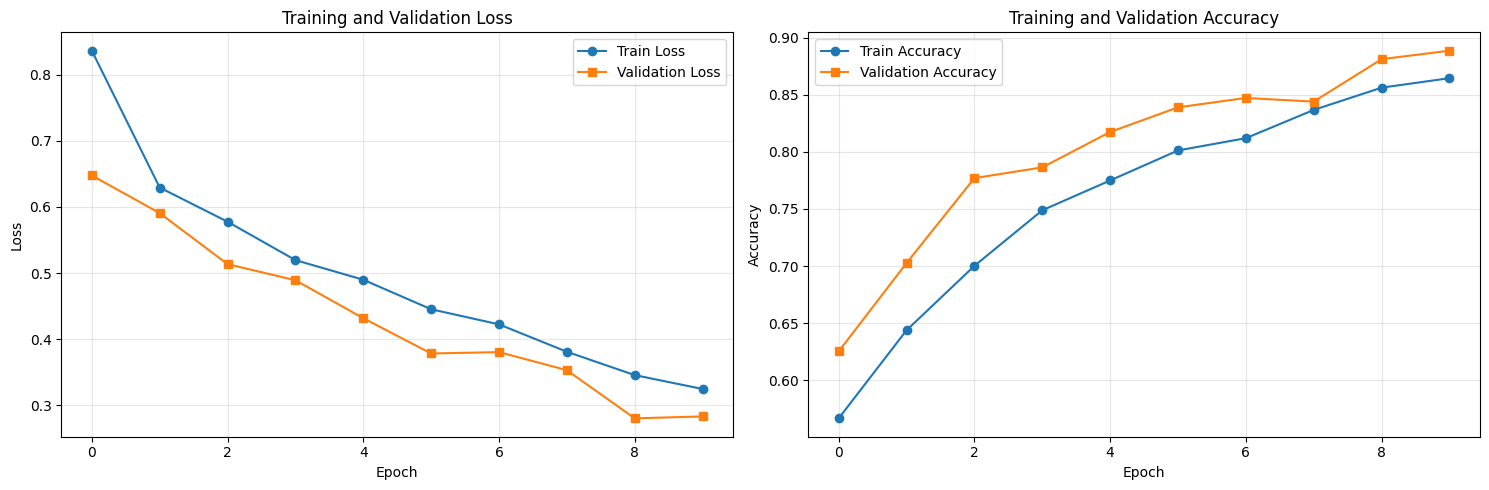

In [11]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(trainer.train_losses, label='Train Loss', marker='o')
ax1.plot(trainer.val_losses, label='Validation Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(trainer.train_accuracies, label='Train Accuracy', marker='o')
ax2.plot(trainer.val_accuracies, label='Validation Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

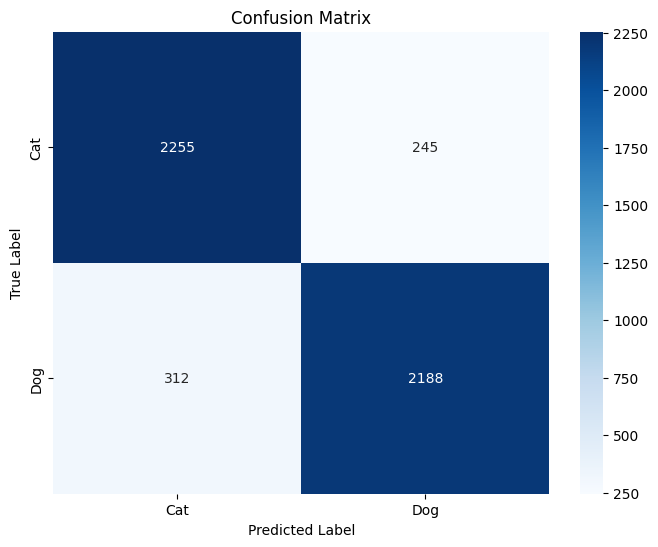


Classification Metrics:
Accuracy:  0.8886
Precision: 0.8993
Recall:    0.8752
F1-Score:  0.8871


In [12]:
# Plot confusion matrix
cm = results['metrics']['confusion_matrix']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Cat', 'Dog'],
           yticklabels=['Cat', 'Dog'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Metrics:")
print(f"Accuracy:  {results['metrics']['accuracy']:.4f}")
print(f"Precision: {results['metrics']['precision']:.4f}")
print(f"Recall:    {results['metrics']['recall']:.4f}")
print(f"F1-Score:  {results['metrics']['f1_score']:.4f}")

## 8. View MLflow Experiments

In [18]:
# Get experiment information
experiment = mlflow.get_experiment_by_name(experiment_name)
print(f"Experiment ID: {experiment.experiment_id}")
print(f"Experiment Name: {experiment.name}")
print(f"Artifact Location: {experiment.artifact_location}")

# Get all runs from this experiment
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
print(f"\nNumber of runs: {len(runs)}")

if len(runs) > 0:
    print("\nLatest Run Metrics:")
    latest_run = runs.iloc[0]
    print(f"Run ID: {latest_run['run_id']}")
    print(f"Val Accuracy: {latest_run.get('metrics.val_accuracy', 'N/A')}")
    print(f"Val Loss: {latest_run.get('metrics.val_loss', 'N/A')}")

Experiment ID: 214365529706689014
Experiment Name: cats-dogs-classification
Artifact Location: file:///Users/tanwin/Desktop/BITS-Mtech/Semester-3/MLO/Assignment-2/notebooks/../mlruns/214365529706689014

Number of runs: 10

Latest Run Metrics:
Run ID: 3f7cf434365348cfbc01ccce6579cffc
Val Accuracy: 0.6766
Val Loss: 0.6130232078254603


In [19]:
# Query and display all runs in a comparison table
import pandas as pd

experiment = mlflow.get_experiment_by_name(experiment_name)
print(f"Experiment ID       : {experiment.experiment_id}")
print(f"Artifact Location   : {experiment.artifact_location}")

runs = mlflow.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.val_accuracy DESC"]
)
print(f"\nTotal runs recorded : {len(runs)}")

if len(runs) > 0:
    display_cols = [
        'run_id',
        'tags.run_name',
        'tags.model_version',
        'params.learning_rate',
        'params.num_epochs',
        'params.batch_size',
        'metrics.val_accuracy',
        'metrics.val_precision',
        'metrics.val_recall',
        'metrics.val_f1_score',
        'metrics.final_val_f1',
    ]
    # Only show columns that exist
    display_cols = [c for c in display_cols if c in runs.columns]
    summary = runs[display_cols].copy()
    summary['run_id'] = summary['run_id'].str[:8] + '...'
    print("\nRun Comparison Table (sorted by val_accuracy ↓):")
    try:
        from IPython.display import display
        display(summary)
    except Exception:
        print(summary.to_string())

    print("\n→ Run `mlflow ui --backend-store-uri ../mlruns` to explore interactively.")
else:
    print("No runs found. Complete training first.")


Experiment ID       : 214365529706689014
Artifact Location   : file:///Users/tanwin/Desktop/BITS-Mtech/Semester-3/MLO/Assignment-2/notebooks/../mlruns/214365529706689014

Total runs recorded : 10

Run Comparison Table (sorted by val_accuracy ↓):


,run_id,params.learning_rate,params.num_epochs,params.batch_size,metrics.val_accuracy,metrics.val_precision,metrics.val_recall,metrics.val_f1_score
0,eadafce3...,0.001,10,32,0.8886,0.899301,0.8752,0.887087
1,0437de24...,0.001,10,32,0.8848,0.856033,0.9252,0.889273
2,cd61f106...,0.001,10,32,0.8686,0.860102,0.8804,0.870132
3,3f7cf434...,0.001,2,32,0.6766,0.712362,0.5924,0.646866
4,e197599a...,0.001,10,32,0.6674,0.755027,0.4956,0.598406
5,b8d06331...,0.001,1,32,0.5908,0.915751,0.2000,0.328299
6,890c9927...,0.001,2,32,0.5000,0.500000,1.0000,0.666667
7,f71a90d8...,0.001,10,32,NaN,NaN,NaN,NaN
8,20784378...,0.001,10,32,NaN,NaN,NaN,NaN
9,6c99a10d...,0.001,10,32,NaN,NaN,NaN,NaN



→ Run `mlflow ui --backend-store-uri ../mlruns` to explore interactively.


## 9. Save Model

The model is already saved during training. Let's verify it.

In [14]:
import os

model_path = '../models/model.pt'

if os.path.exists(model_path):
    model_size = os.path.getsize(model_path) / (1024 * 1024)  # Size in MB
    print(f"✓ Model saved successfully!")
    print(f"  Location: {model_path}")
    print(f"  Size: {model_size:.2f} MB")
else:
    print("✗ Model file not found!")

✓ Model saved successfully!
  Location: ../models/model.pt
  Size: 99.75 MB


## 10. Load and Test Saved Model

In [21]:
from src.model import load_model
model_path = '../models/model.pt'

# Load the saved model
loaded_model = load_model(model_path, device='cpu')
loaded_model.eval()

print("✓ Model loaded successfully!")

# Test prediction with a sample
with torch.no_grad():
    sample_input = val_loader.dataset[0][0].unsqueeze(0)  # Take first validation sample and add batch dimension
    sample_label = val_loader.dataset[0][1]

    output = loaded_model(sample_input)
    probabilities = torch.softmax(output, dim=1)[0]
    predicted_class = torch.argmax(probabilities).item()
    
    class_names = ['Cat', 'Dog']
    print(f"\nTest Prediction:")
    print(f"  True Label: {class_names[sample_label]}")
    print(f"  Predicted: {class_names[predicted_class]}")
    print(f"  Confidence: {probabilities[predicted_class]:.4f}")
    print(f"  Probabilities: Cat={probabilities[0]:.4f}, Dog={probabilities[1]:.4f}")

✓ Model loaded successfully!

Test Prediction:
  True Label: Dog
  Predicted: Dog
  Confidence: 0.5316
  Probabilities: Cat=0.4684, Dog=0.5316


## Summary

### ✓ Completed Tasks:

1. **Data & Code Versioning**
   - Git initialized for code versioning
   - DVC configured for data versioning
   - Data tracked in `.dvc` files

2. **Model Building**
   - SimpleCNN architecture implemented
   - Model trained on dummy dataset
   - Model saved in `.pt` format

3. **Experiment Tracking**
   - MLflow tracking configured
   - Parameters logged (learning rate, batch size, epochs)
   - Metrics logged (loss, accuracy, precision, recall, F1)
   - Artifacts saved (confusion matrix, training curves, model)

### Next Steps:
- Run `mlflow ui` in terminal to view experiment dashboard
- Replace dummy data with actual Cats vs Dogs dataset
- Tune hyperparameters for better performance
- Proceed to M2 for model packaging and containerization